# Try to calculate scattered light image


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits

from scipy.signal import convolve2d
from scipy.signal import convolve, oaconvolve
from PIL import Image, ImageChops
from astropy.convolution import convolve_fft

import sys

from matplotlib.gridspec import GridSpec
from matplotlib import colors

## Functions

In [2]:
def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*1/rng #normalised to [0,1]

def compare(img1, img2):
    # normalize to compensate for exposure difference
    
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = np.sum(abs(diff))/np.sum(img1)  

    return m_norm





def Loadimages(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    print(dir,qfile)
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]
                
    return image, n

def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n




def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for IRDIS
    d = (n-1) * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout
    
    
    
def plot_with_same_color(data, keys, labels,title,star,lim1,arcsinh):
    
    num_keys = len(keys)
    ncols = int(np.ceil(np.sqrt(num_keys)))  # Adjust the number of rows as needed
    nrows = int(np.ceil(num_keys / ncols))
    fig = plt.figure(figsize=(12, 8))
    data_arcshin={}
    for key in keys:
        print(key)
        if arcsinh==True:
            data_arcshin[key] =np.arcsinh(data[key]) 
        else:
            data_arcshin[key] = data[key]*1.
    # Using GridSpec to create a more flexible subplot layout
       
    gs = GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.25)
    # Calculate vmin and vmax for all images
    n = data_arcshin[key].shape[0]
    vmin = np.min([np.min(data_arcshin[key][int(n/2-lim1):int(n/2+lim1), int(n/2-lim1):int(n/2+lim1)]) for key in keys])
    vmax = np.max([np.max(data_arcshin[key][int(n/2-lim1):int(n/2+lim1), int(n/2-lim1):int(n/2+lim1)]) for key in keys])
    for idx, key in enumerate(keys):
        
        ps=3.6
        lim=lim1*1.
            
        ax = fig.add_subplot(gs[idx])
        n = data_arcshin[key].shape[0]
        d = (n-1) * ps / 2
        im = ax.imshow(data_arcshin[key], extent=(-d, d, -d, d), vmin=vmin, vmax=vmax,origin='lower')
        #plotting contour
        if arcsinh:
            levels=[np.arcsinh(np.max(data[key])/16),np.arcsinh(np.max(data[key])/8),np.arcsinh(np.max(data[key])/4),np.arcsinh(np.max(data[key])/2)]
        else:
            levels=[np.max(data[key])/16,np.max(data[key])/8,np.max(data[key])/4,np.max(data[key])/2]
        CS=ax.contour(data_arcshin[key], levels=levels,colors=['red','purple','pink','white'], extent=(-d, d, -d, d))
        ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_title(labels[key])
        ax.set_xlabel('mas')
        ax.set_ylabel('mas')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.label_outer()

    # Create a common colorbar for all images
    cax = fig.add_axes([0.95, 0.22, 0.02, 0.55])  # Adjust the position of colorbar as needed
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(star+' '+title, fontsize=16)#,y=0.85)

    #specific_folder=figfolder+'models/'
    #try:
    # Create target Directory
    #   os.mkdir(specific_folder)
    #except FileExistsError:
    #    print("Directory " , specific_folder,  " already exists")
   
    #plt.savefig(specific_folder +star+'_'+title+".jpeg",bbox_inches='tight', pad_inches=0.1)
    #plt.show()

## Star Set up

In [3]:
#dirdat = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/'
#fig_folder= '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/'

stars=['AR_Pup_dc_notnorm','HR4049_20190108','HR4049_20190107',"HR4049_combined",'V709_Car','HR4226','UMon_Katya']
#stars=['AR_Pup_dc_notnorm']
#stars = ['IRAS08544-4431','IRAS08544-4431_dc_notnorm','UMon']
star = stars[1]

stars_type={'HD83878':'ref','IRAS08544-4431_dc_notnorm':'sci','HD75885':'ref', 'AR_Pup_dc_notnorm':'sci','UMon':'sci','UMon_Katya':'sci','HR4049_20190108':'sci','HR4049_20190107':'sci','HD71253':'ref','HD94680':'ref','HD96314':'ref','HD98025':'ref','V709_Car':'sci','HR4226':'sci'}
ref_of_sci={'AR_Pup_dc_notnorm':'HD71253','UMon':'HD71253','UMon_Katya':'HD71253','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals

#HD75885

fittype='I'
#otherfittype=['I_pol']

bands=['I','V']

N_decon = 200


AR_Pup_dc_notnorm
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/AR_Pup_dc_notnorm/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_I_I_meancombined.fits
AR_Pup_dc_notnorm_I_I_meancombined.fits
0.72227573
1024
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_I_PI_meancombined.fits
AR_Pup_dc_notnorm_I_PI_meancombined.fits
0.0
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/AR_Pup_dc_notnorm/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_V_I_meancombined.fits
AR_Pup_dc_notnorm_V_I_meancombined.fits
1.036089
1024
/media/katery

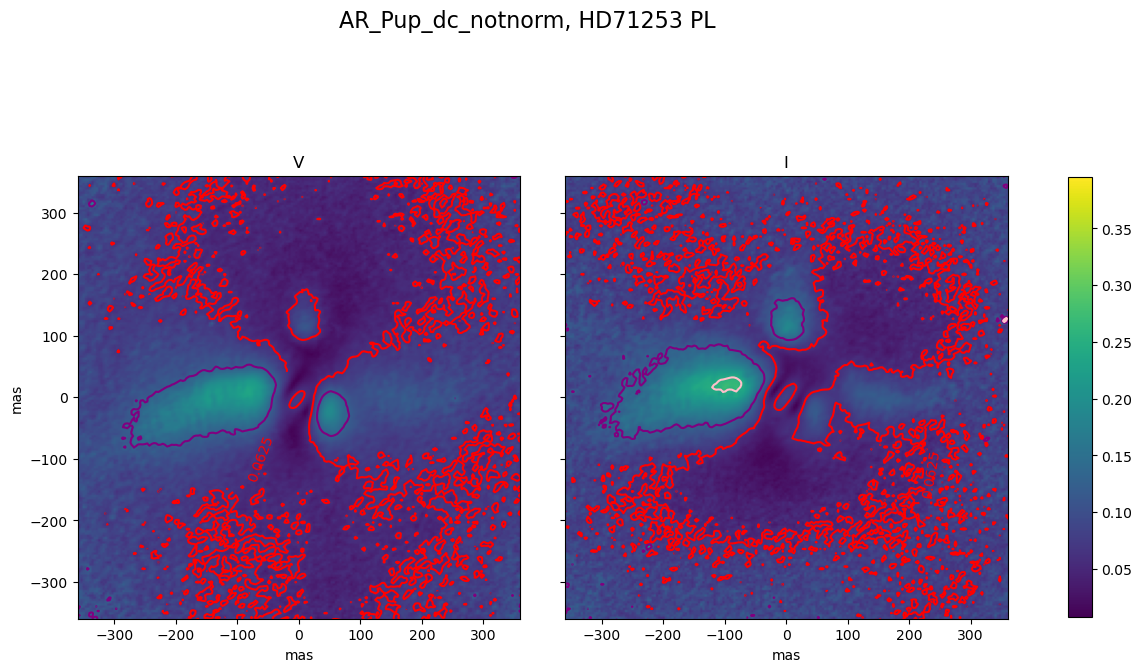

V
I


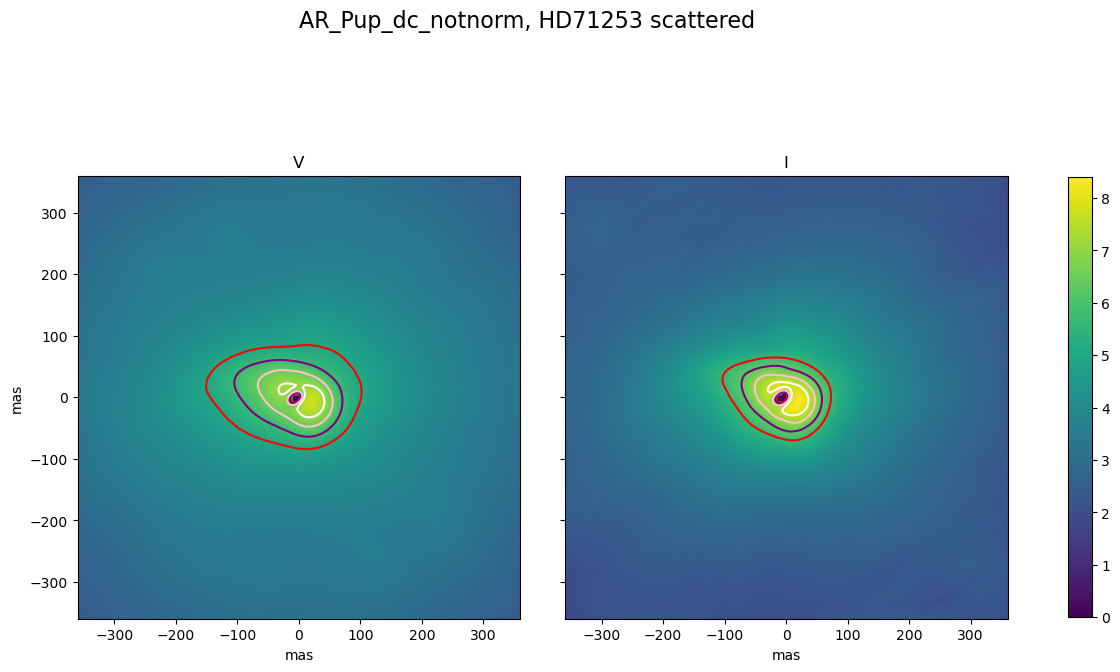

HR4049_20190108
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/HR4049_20190108/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4049_20190108/ HR4049_20190108_I_I_meancombined.fits
HR4049_20190108_I_I_meancombined.fits
-0.12701756
1024
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4049_20190108/ HR4049_20190108_I_PI_meancombined.fits
HR4049_20190108_I_PI_meancombined.fits
0.0
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/HR4049_20190108/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4049_20190108/ HR4049_20190108_V_I_meancombined.fits
HR4049_20190108_V_I_meancombined.fits
0.5288787
1024
/media/kateryna/Data_Lin/PhD/SPHERE

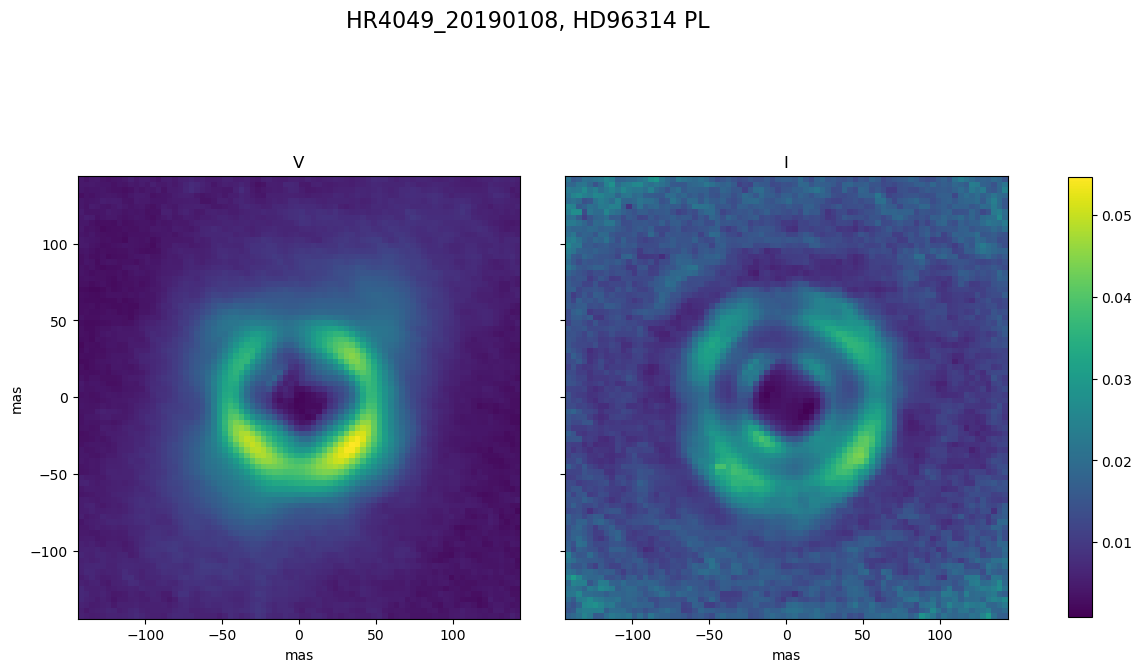

V
I


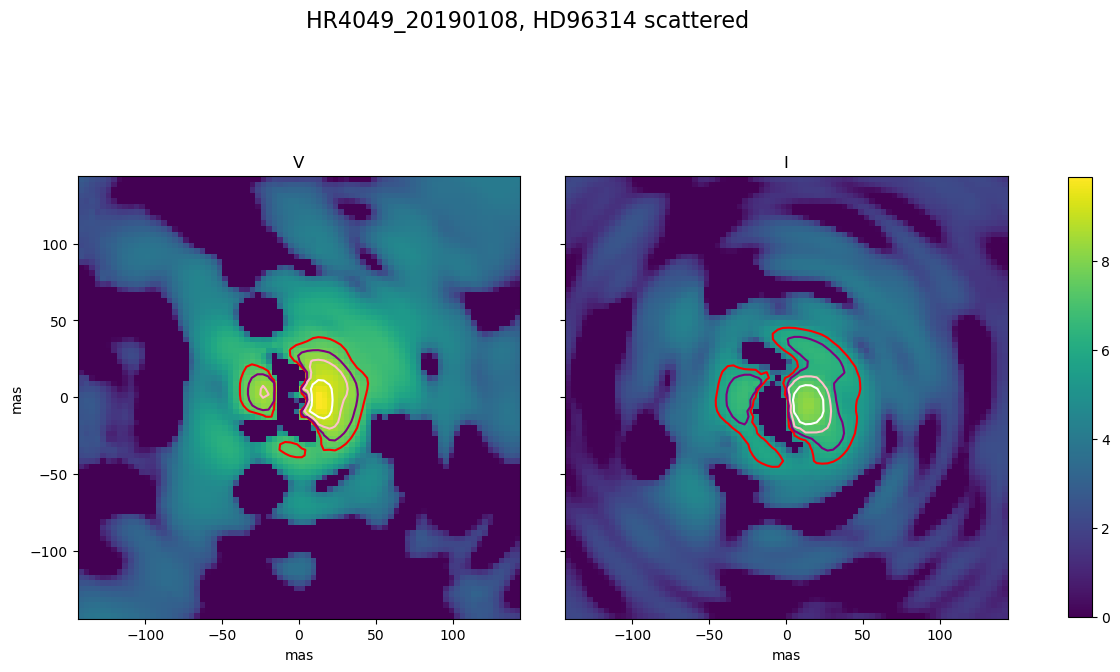

HR4049_20190107
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/HR4049_20190107/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4049_20190107/ HR4049_20190107_I_I_meancombined.fits
HR4049_20190107_I_I_meancombined.fits
-0.06645287
1024
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4049_20190107/ HR4049_20190107_I_PI_meancombined.fits
HR4049_20190107_I_PI_meancombined.fits
0.0
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/HR4049_20190107/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4049_20190107/ HR4049_20190107_V_I_meancombined.fits
HR4049_20190107_V_I_meancombined.fits
0.848174
1024
/media/kateryna/Data_Lin/PhD/SPHERE_

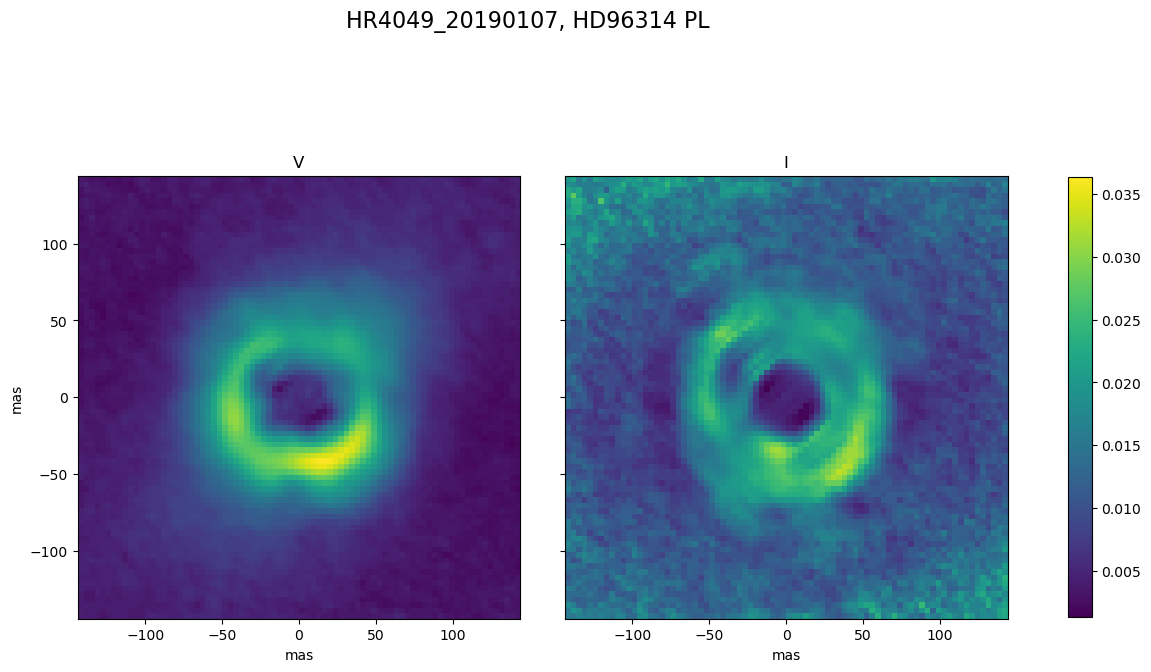

V
I


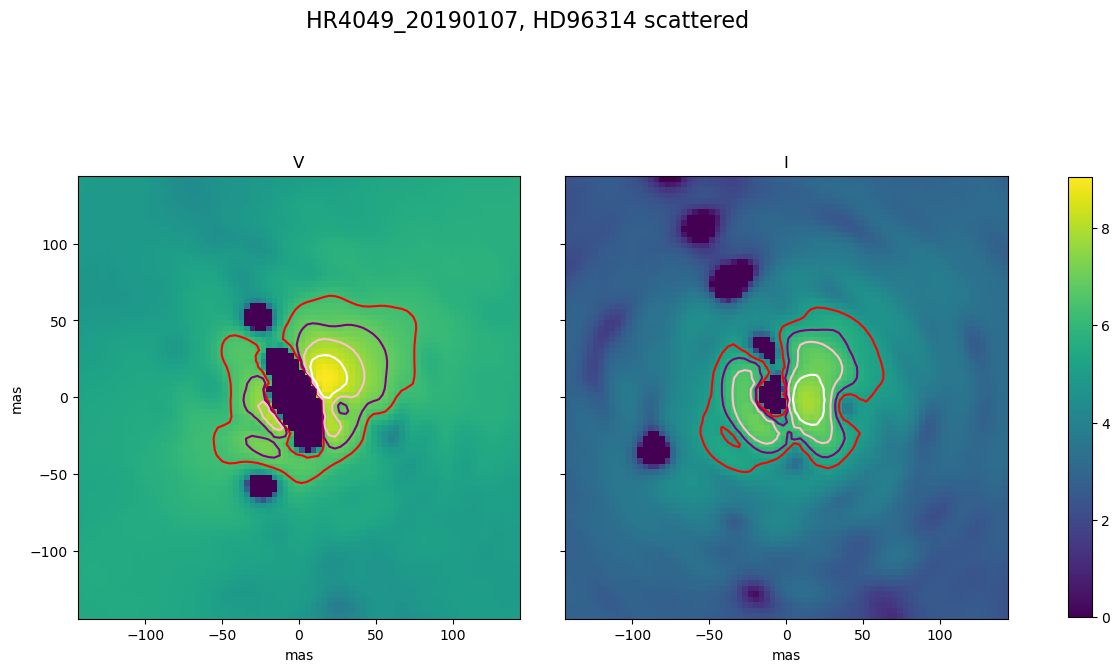

HR4049_combined
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/HR4049_combined/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4049_combined/ HR4049_combined_I_I_meancombined.fits
HR4049_combined_I_I_meancombined.fits
-0.09457219
1024
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4049_combined/ HR4049_combined_I_PI_meancombined.fits
HR4049_combined_I_PI_meancombined.fits
0.0
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/HR4049_combined/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4049_combined/ HR4049_combined_V_I_meancombined.fits
HR4049_combined_V_I_meancombined.fits
0.6999298
1024
/media/kateryna/Data_Lin/PhD/SPHERE

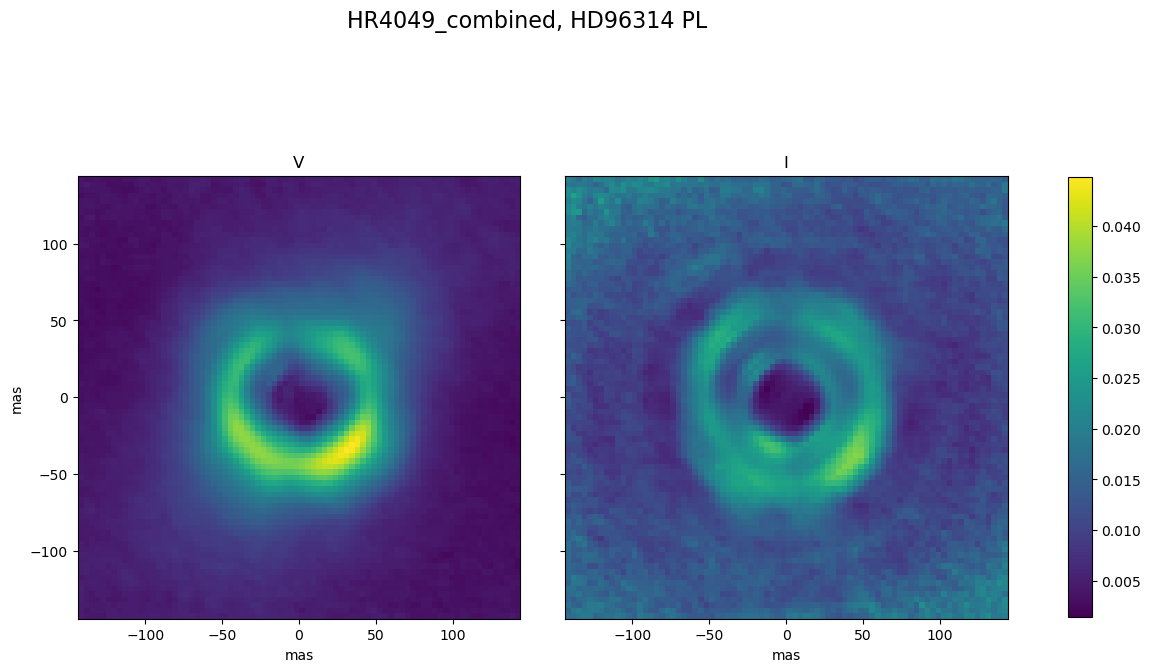

V
I


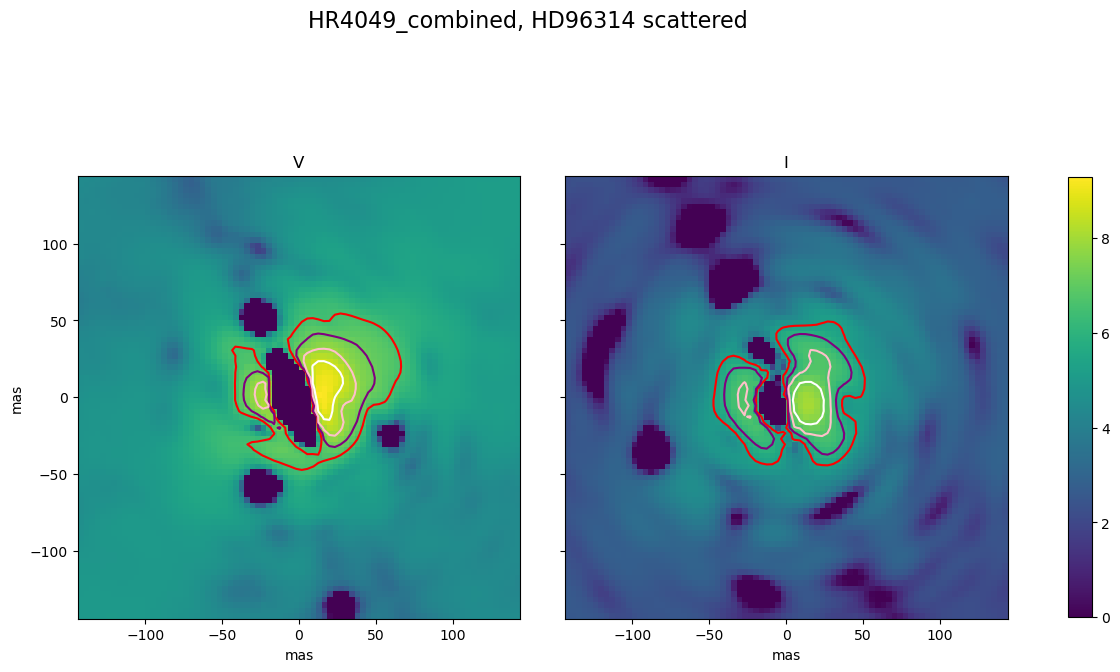

V709_Car
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/V709_Car/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/V709_Car/ V709_Car_I_I_meancombined.fits
V709_Car_I_I_meancombined.fits
1.0402395
1024
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/V709_Car/ V709_Car_I_PI_meancombined.fits
V709_Car_I_PI_meancombined.fits
0.0
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/V709_Car/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/V709_Car/ V709_Car_V_I_meancombined.fits
V709_Car_V_I_meancombined.fits
0.50465566
1024
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/V709_Car/ V709_Car_V_PI_meancombined.fits
V709_C

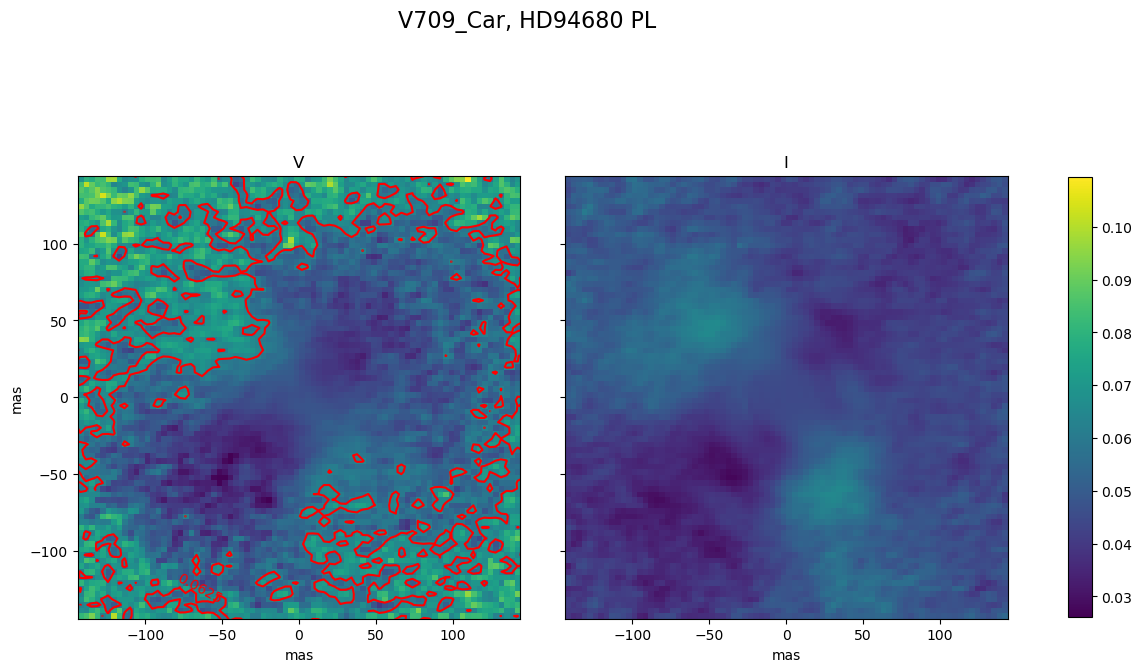

V
I


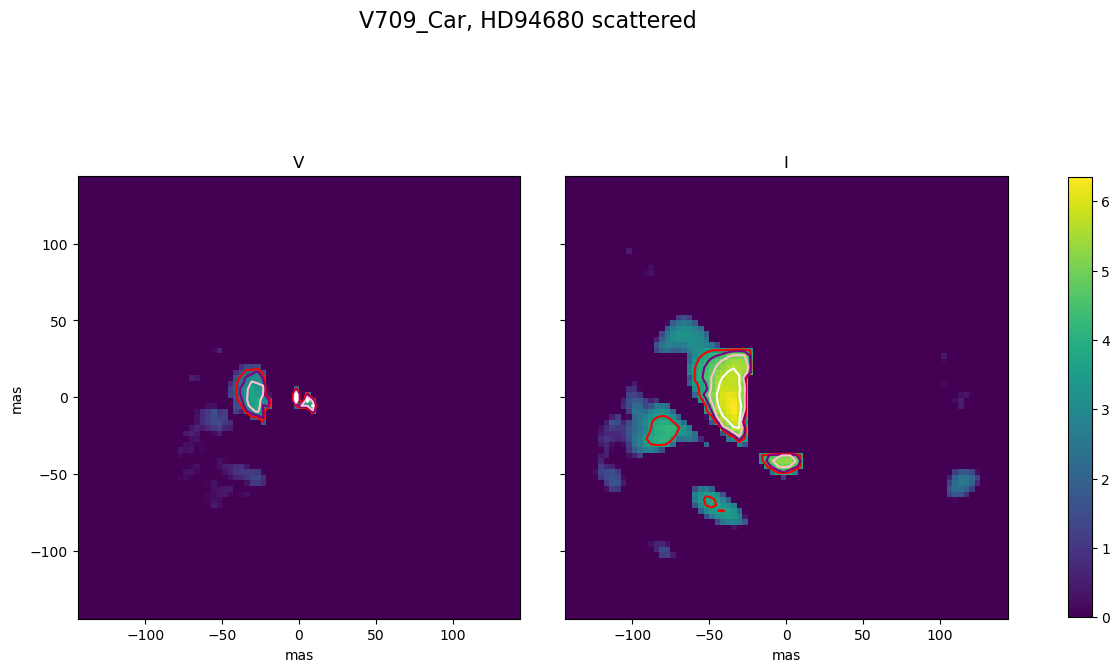

HR4226
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/HR4226/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4226/ HR4226_I_I_meancombined.fits
HR4226_I_I_meancombined.fits
1.06267
1024
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4226/ HR4226_I_PI_meancombined.fits
HR4226_I_PI_meancombined.fits
0.0
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/HR4226/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4226/ HR4226_V_I_meancombined.fits
HR4226_V_I_meancombined.fits
0.7250312
1024
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/HR4226/ HR4226_V_PI_meancombined.fits
HR4226_V_PI_meancombined.fits
0.0
V
I

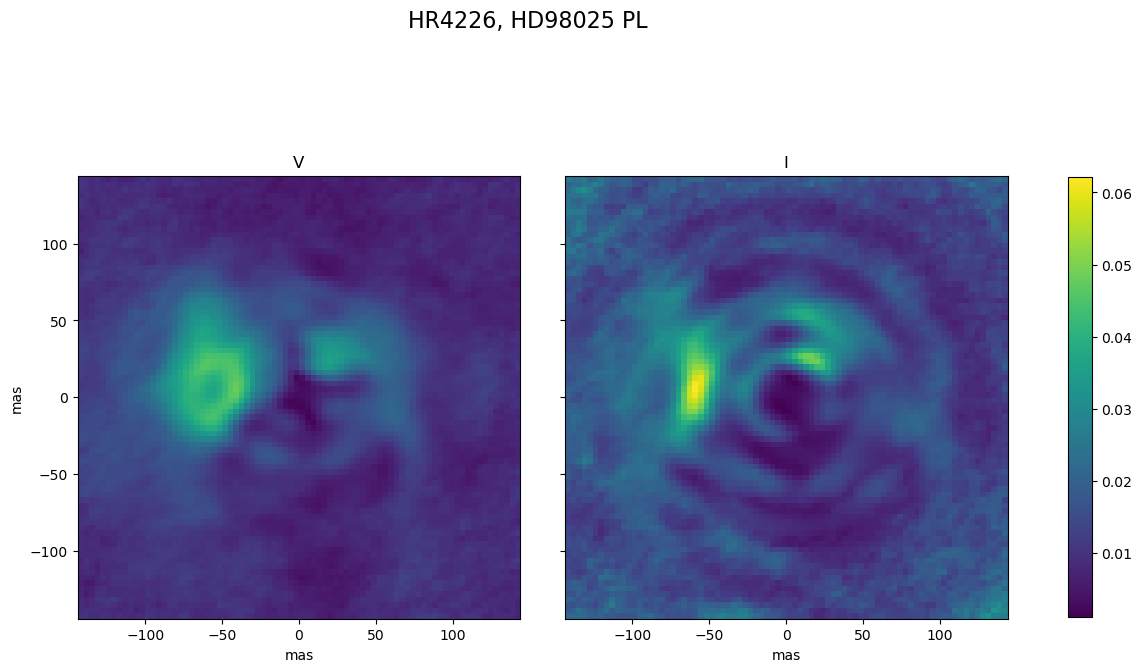

V
I


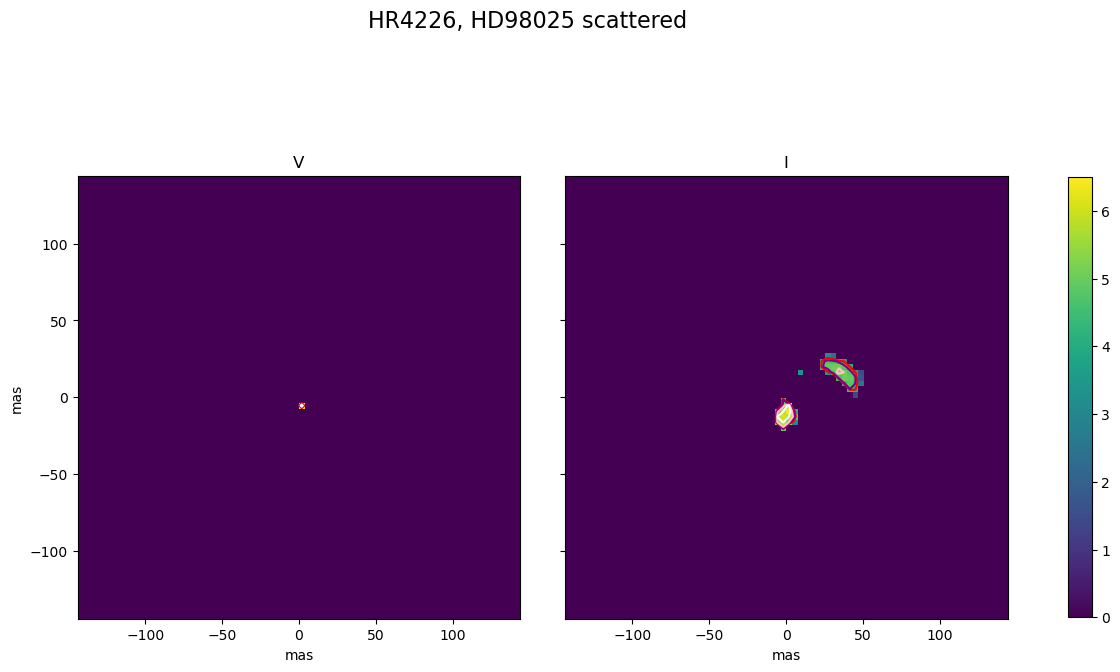

UMon_Katya
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/UMon_Katya/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/UMon_Katya/ UMon_Katya_I_I_meancombined.fits
UMon_Katya_I_I_meancombined.fits
5.8860106
1024
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/UMon_Katya/ UMon_Katya_I_PI_meancombined.fits
UMon_Katya_I_PI_meancombined.fits
0.0
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/  already exists
Directory  /media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Scattered/UMon_Katya/  already exists
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/UMon_Katya/ UMon_Katya_V_I_meancombined.fits
UMon_Katya_V_I_meancombined.fits
0.34676272
1024
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/UMon_Katya/ UMon_Katya_V

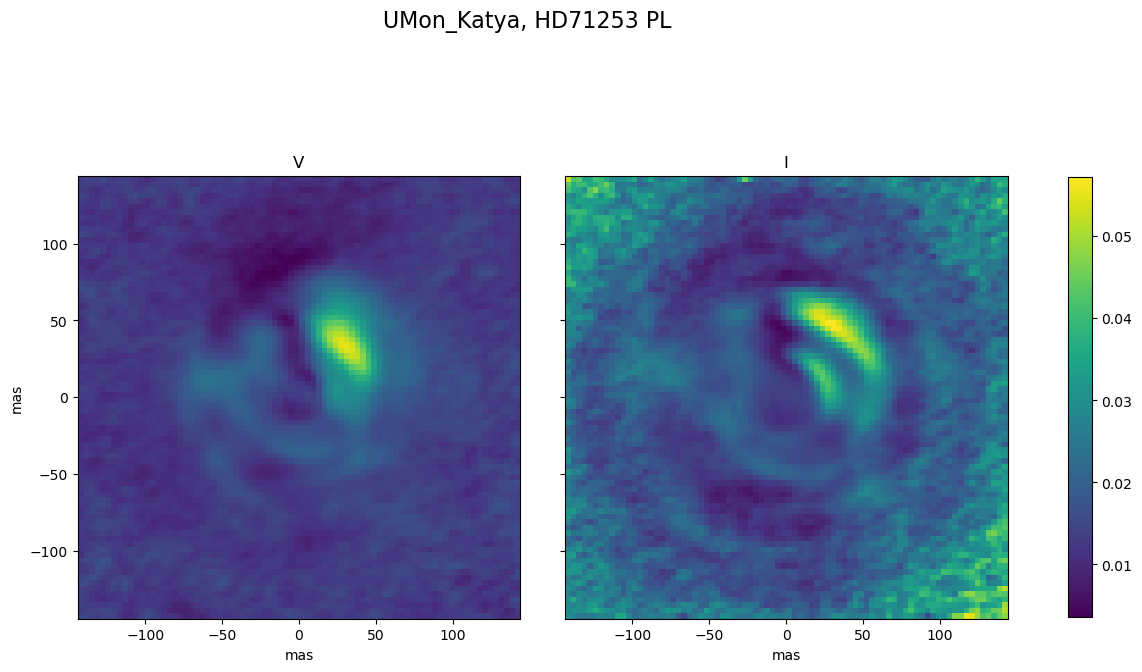

V
I


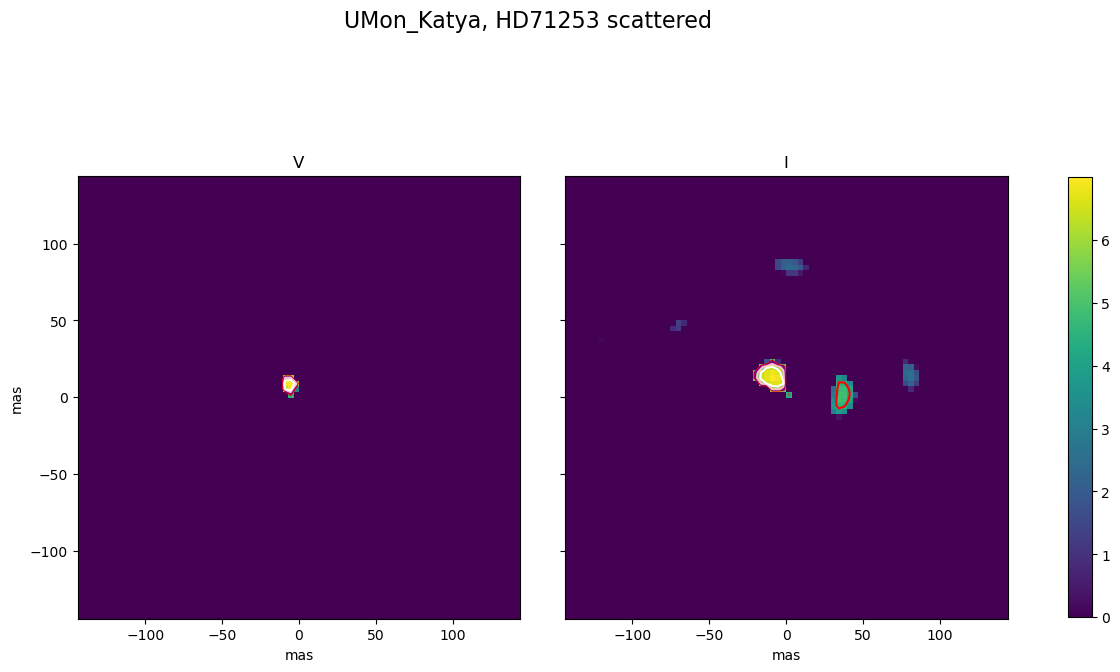

In [9]:
dirdat0 = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/' 

for star in stars:
    print(star)
    if star=='AR_Pup_dc_notnorm':
        lim=100
    else:
        lim=40
    dirdat =dirdat0+'Unres+PSFcorr/'+star+'/'

    for band in bands:
        dirName1=dirdat0+'Scattered'+'/'
        try:
        # Create target Directory
           os.mkdir(dirName1)
        except FileExistsError:
            print("Directory " , dirName1 ,  " already exists")

        dirName=dirName1+star+'/'
        try:
        # Create target Directory
           os.mkdir(dirName)
        except FileExistsError:
            print("Directory " , dirName ,  " already exists")


        #dirName2#=dirName1 #for creating folders for the second half of deconvolution (for the u_phi and i_pol)

        image=[]
        PSF=[]
        ps=3.6

        I, n=Loadimages(star,'I',dirdat,band,'_meancombined') #+PSF_smear
        PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band)
        PI,n= Loadimages(star,'PI',dirdat,band,'_meancombined')
        
        a=int(300)#int(n/2.-20*ps)
        b=int(n-300)#int(n/2.+20*ps)
        psf=PSF#[a:b,a:b]
        I=I#[a:b,a:b]
        PI=PI#[a:b,a:b]
        x = np.linspace(-n/2., n/2., num=n)
        y = np.linspace(-n/2., n/2., num=n)
        x0 = 0.5
        y0 = 0.5
        x = x-x0
        y = y-y0
        X, Y = np.meshgrid(x, y)
        R = np.sqrt(X**2 + Y**2)

        

        plotImage(I, lim)
        plt.savefig(dirName+ star +"_"+band+"_"+fittype+"_image.png",bbox_inches='tight', pad_inches=0.1)
        plt.close()



        plotImage(psf, lim)
        plt.savefig(dirName+star +"_"+band+ "_PSF.png",bbox_inches='tight', pad_inches=0.1)
        plt.close()


        scattered=I-psf*(np.max(I)/np.max(psf))
        scattered=scattered*(scattered>=0)+1e-16*(scattered<0)
        plotImage(scattered, lim)
        plt.savefig(dirName+star +"_"+band+ "_scattered.png",bbox_inches='tight', pad_inches=0.1)
        plt.close()


        pl=np.divide(PI,I,where=I>1)
        pl=pl*(pl<=1)+pl*1e-18
        n = pl.shape[0]

        fig, ax = plt.subplots()
        image_plot = pl
        max = np.max(image_plot[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        min=np.min(image_plot[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        d = (n-1) * ps / 2
        plt.imshow(image_plot, vmin=min, vmax=max, extent=(-d, d, d, -d))
        #plt.plot(0, 0, "+", color="red")
        plt.xlim(-lim * ps, lim * ps)
        plt.ylim(-lim * ps, lim * ps)
        plt.xlabel('mas')
        plt.ylabel("mas")
        plt.colorbar()
        plt.tight_layout
        plt.savefig(dirName+star +"_"+band+ "_pl.png",bbox_inches='tight', pad_inches=0.1)
        plt.close()
        
        
        if band=='I':
            pl_I=pl
            scattered_I=scattered
            
        if band=='V':
            pl_V=pl
            scattered_V=scattered
            plotImage(pl_V, lim)
            plt.savefig(dirName+"test.png",bbox_inches='tight', pad_inches=0.1)
            plt.close()
        
        
    keys=['V','I']
    labels={'V':'V','I':'I'}
    data={'V': pl_V ,'I':pl_I}
    plot_with_same_color(data, keys, labels ,'PL',star+', '+ref_of_sci[star],lim,False)
    plt.savefig(dirName+star+'_pl_both_bands.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    data={'V': scattered_V ,'I':scattered_I}
    plot_with_same_color(data, keys, labels ,'scattered',star+', '+ref_of_sci[star],lim,True)
    plt.savefig(dirName+star+'_scattered_both_bands.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

In [ ]:
dirdat0 = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/' 
print(star)

dirdat =dirdat0+'Unres+PSFcorr/'+star+'/'

for band in bands:
    dirName1=dirdat0+'Scattered'+'/'
    try:
    # Create target Directory
       os.mkdir(dirName1)
    except FileExistsError:
        print("Directory " , dirName1 ,  " already exists")

    dirName=dirName1+star+'/'
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")


    #dirName2#=dirName1 #for creating folders for the second half of deconvolution (for the u_phi and i_pol)

    image=[]
    PSF=[]
    ps=3.6

    image, n=Loadimages(star,fittype,dirdat,band,'_meancombined') #+PSF_smear
    print(ref_of_sci[star])
    PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band)

    print(n)

    a=int(300)#int(n/2.-20*ps)
    b=int(n-300)#int(n/2.+20*ps)
    psf=PSF[a:b,a:b]
    image=image[a:b,a:b]

    x = np.linspace(-n/2., n/2., num=n)
    y = np.linspace(-n/2., n/2., num=n)
    x0 = 0.5
    y0 = 0.5
    x = x-x0
    y = y-y0
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)

    lim=60

    plotImage(image, lim)
    plt.savefig(dirName+ star +"_"+band+"_"+fittype+"_image.png",bbox_inches='tight', pad_inches=0.1)
    plt.close()



    plotImage(psf, lim)
    plt.savefig(dirName+star +"_"+band+ "_PSF.png",bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
    
    scattered=image-psf*(np.max(image)/np.max(psf))
    
    plotImage(scattered, lim)
    plt.savefig(dirName+star +"_"+band+ "_scattered.png",bbox_inches='tight', pad_inches=0.1)
    plt.close()